# Assignment 4: Agentic RAG System (LangGraph + Azure OpenAI)

This notebook implements a simplified Agentic RAG (Retrieval-Augmented Generation) pipeline using LangGraph, AzureChatOpenAI, and a small software best-practices knowledge base.

## What It Does
For a user question:
1. Retrieves top-5 relevant snippets from a knowledge base (vector search).
2. Generates an initial answer using the retrieved context and Azure OpenAI.
3. Self-critiques the answer to check for completeness.
4. If incomplete, refines the answer using one additional snippet.
5. Returns the final answer with citations.

## Key Components
- **Vector DB**: ChromaDB (stores embedded KB snippets)
- **Embedding Model**: `all-MiniLM-L6-v2` (via `sentence-transformers`)
- **LLM**: `AzureChatOpenAI` (GPT-4 via Azure)
- **LangGraph**: Manages end-to-end control flow across nodes:
  - `retrieve_kb`
  - `generate_answer`
  - `critique_answer`
  - `refine_answer`

## Required Environment Variables
Set these in your environment:
- `AZURE_OPENAI_API_KEY`
- `AZURE_OPENAI_API_BASE`
- `AZURE_OPENAI_DEPLOYMENT`
- `AZURE_OPENAI_API_VERSION` (use `2024-12-01-preview`)



In [13]:
#!pip install openai langgraph chromadb sentence-transformers pydantic


In [ ]:
import os, json
from typing import List, Dict
from pydantic import BaseModel
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings
from langchain.chat_models import AzureChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langgraph.graph import StateGraph, END

# Azure OpenAI setup
llm = AzureChatOpenAI(
    deployment_name="myllm",
    temperature=0.2,
    openai_api_key="",
    openai_api_base="",
    openai_api_version="2024-12-01-preview"
)

c:\One-Drive\OneDrive - Tredence\Desktop\databricks_genai_hackt-main\agenticAI\AgenticAIWorkspace\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\4265666793.py:13: LangChainDeprecationWarning: The class `AzureChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import AzureChatOpenAI``.
  llm = AzureChatOpenAI(
c:\One-Drive\OneDrive - Tredence\Desktop\databricks_genai_hackt-main\agenticAI\AgenticAIWorkspace\.venv\Lib\site-packages\langchain_community\chat_models\azure_openai.py:174: UserWarning: As of openai>=1.0.0, Azure endpo

In [3]:
client = chromadb.Client(Settings())
collection = client.create_collection("kb_index_new")

with open("self_critique_loop_dataset.json") as f:
    kb_data = json.load(f)

embedder = SentenceTransformer("all-MiniLM-L6-v2")

for entry in kb_data:
    emb = embedder.encode(entry["answer_snippet"]).tolist()
    collection.add(
        ids=[entry["doc_id"]],
        documents=[entry["answer_snippet"]],
        embeddings=[emb],
        metadatas=[{
            "source": entry["source"],
            "last_updated": entry["last_updated"]
        }]
    )

print(f"Indexed {len(kb_data)} documents into Chroma.")


Indexed 30 documents into Chroma.


In [8]:
from langchain.chat_models import ChatOpenAI
from langgraph.graph import StateGraph, END


# Pydantic Schema
class MeetingNotes(BaseModel):
    summary: str
    action_items: List[str]



from typing import List, Dict, Optional
from pydantic import BaseModel

class RAGState(BaseModel):
    user_question: str
    kb_hits: Optional[List[Dict]] = None
    initial_answer: Optional[str] = None
    critique_result: Optional[str] = None
    answer: Optional[str] = None


# Retriever node function
def retrieve_kb(query: str, top_k=5):
    q_vec = embedder.encode(query).tolist()
    results = collection.query(query_embeddings=[q_vec], n_results=top_k)
    return [
        {"doc_id": doc_id, "answer_snippet": doc, "source": meta["source"]}
        for doc_id, doc, meta in zip(results["ids"][0], results["documents"][0], results["metadatas"][0])
    ]

def generate_text(kb_hits):
    return "\n".join([f"[{hit['doc_id']}] {hit['answer_snippet']}" for hit in kb_hits])



def retrieve_kb_node(state: RAGState) -> RAGState:
    hits = retrieve_kb(state.user_question)
    return state.copy(update={"kb_hits": hits})



In [9]:
from langchain.chains import LLMChain
from langchain.prompts import ChatPromptTemplate

# Generate node
generate_prompt = ChatPromptTemplate.from_template(
    "You are a software best-practices assistant.\n"
    "User Question:\n{user_question}\n\n"
    "Retrieved Snippets:\n{kb_text}\n\n"
    "Task:\nBased on these snippets, write a concise answer. Cite doc_ids in [brackets]."
)
generate_chain = LLMChain(llm=llm, prompt=generate_prompt)

def generate_node(state: RAGState) -> RAGState:
    kb_text = generate_text(state.kb_hits)
    answer = generate_chain.run({
        "user_question": state.user_question,
        "kb_text": kb_text
    })
    return state.copy(update={"initial_answer": answer})


# Critique node
critique_prompt = ChatPromptTemplate.from_template(
    "You are a critical QA assistant.\n"
    "Question: {user_question}\n"
    "Initial Answer: {initial_answer}\n"
    "KB Snippets:\n{kb_text}\n"
    "If complete, respond: COMPLETE.\nElse: REFINE: <missing topics>"
)
critique_chain = LLMChain(llm=llm, prompt=critique_prompt)

def critique_node(state: RAGState) -> RAGState:
    kb_text = generate_text(state.kb_hits)
    critique = critique_chain.run({
        "user_question": state.user_question,
        "initial_answer": state.initial_answer,
        "kb_text": kb_text
    })
    return state.copy(update={"critique_result": critique})


# Refine node
refine_prompt = ChatPromptTemplate.from_template(
    "You are refining an answer.\n"
    "Question: {user_question}\n"
    "Initial Answer: {initial_answer}\n"
    "Critique: {critique_result}\n"
    "Additional Snippet:\n{kb_text}\n"
    "Return the refined answer citing doc_ids."
)

def refine_node(state: RAGState) -> RAGState:
    if not state.critique_result or "REFINE:" not in state.critique_result:
        return state.copy(update={"answer": state.initial_answer})

    missing = state.critique_result.split("REFINE:")[1].strip()
    extra_hit = retrieve_kb(f"{state.user_question} and {missing}", top_k=1)
    extra_text = generate_text(extra_hit)

    refined_answer = LLMChain(llm=llm, prompt=refine_prompt).run({
        "user_question": state.user_question,
        "initial_answer": state.initial_answer,
        "critique_result": state.critique_result,
        "kb_text": extra_text
    })

    return state.copy(update={"answer": refined_answer})



C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\1644381072.py:11: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  generate_chain = LLMChain(llm=llm, prompt=generate_prompt)


In [15]:
from langgraph.graph import StateGraph, END

builder = StateGraph(state_schema=RAGState)
builder.add_node("retrieve_kb", lambda s: RAGState(user_question=s.user_question, kb_hits=retrieve_kb(s.user_question)))
builder.add_node("generate_answer", generate_node)
builder.add_node("critique_answer", critique_node)
builder.add_node("refine_answer", refine_node)

builder.set_entry_point("retrieve_kb")
builder.add_edge("retrieve_kb", "generate_answer")
builder.add_edge("generate_answer", "critique_answer")

def check_refinement(state: RAGState):
    return "refine_answer" if state.critique_result and "REFINE:" in state.critique_result else END

builder.add_conditional_edges("critique_answer", check_refinement)
builder.add_edge("refine_answer", END)

graph = builder.compile()


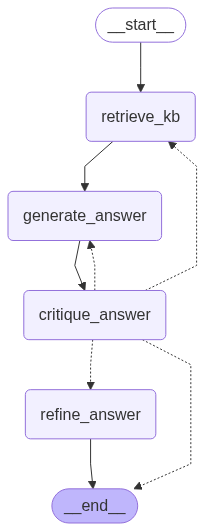

In [16]:
graph

In [11]:
queries = [
    "What are best practices for caching?",
    "How should I set up CI/CD pipelines?",
    "What are performance tuning tips?",
    "How do I version my APIs?",
    "What should I consider for error handling?"
]

for q in queries:
    print(f"\nQuestion: {q}")
    output = graph.invoke({"user_question": q})
    print("Final Answer:\n", output["answer"])



Question: What are best practices for caching?


C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\1644381072.py:15: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  answer = generate_chain.run({
C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\1644381072.py:19: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return state.copy(update={"initial_answer": answer})
C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\1644381072.py:39: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V

Final Answer:
 When implementing caching, it's crucial to adhere to well-defined patterns to ensure efficiency and reliability. Key best practices include:

1. **Define Cache Strategy**: Choose between different caching strategies such as in-memory caching, distributed caching, or CDN caching based on your application's needs.

2. **Set Expiration Policies**: Implement appropriate expiration times for cached data to ensure that stale data is not served.

3. **Cache Invalidation**: Establish clear rules for when and how cached data should be invalidated to maintain data consistency.

4. **Monitor Cache Performance**: Regularly monitor cache hit/miss ratios and performance metrics to optimize caching strategies.

5. **Fallback Mechanisms**: Implement fallback mechanisms to handle cache misses gracefully, ensuring that your application can still function without cached data.

6. **Cache Granularity**: Determine the appropriate level of granularity for cached data (e.g., caching entire obj

C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\1644381072.py:19: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return state.copy(update={"initial_answer": answer})
C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\1644381072.py:39: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return state.copy(update={"critique_result": critique})
C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\1644381072.py:67: PydanticDeprecatedSince20: The `copy` method is depr

Final Answer:
 To set up CI/CD pipelines effectively, follow these steps to ensure a robust and efficient process:

1. **Select CI/CD Tools**: Choose appropriate CI/CD tools that fit your project needs. Popular options include Jenkins, GitLab CI, CircleCI, and Travis CI. Evaluate their features, integrations, and community support.

2. **Configure Environments**: Set up different environments for development, testing, and production. This allows you to test changes in a controlled setting before deploying to production.

3. **Define Triggers for Builds**: Establish triggers for your CI/CD pipeline, such as code commits, pull requests, or scheduled builds. This ensures that your pipeline runs automatically when changes are made.

4. **Integrate with Version Control Systems**: Connect your CI/CD pipeline to a version control system like Git. This integration allows for seamless code updates and version tracking.

5. **Automate Testing**: Include automated testing stages in your pipeline.

C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\1644381072.py:19: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return state.copy(update={"initial_answer": answer})
C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\1644381072.py:39: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return state.copy(update={"critique_result": critique})
C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\1644381072.py:67: PydanticDeprecatedSince20: The `copy` method is depr

Final Answer:
 Refined Answer: When addressing performance tuning, it's crucial to follow well-defined patterns to ensure efficiency and effectiveness. Here are some key tips to enhance the performance of your application:

1. **Identify Bottlenecks**: Utilize profiling tools to pinpoint areas where performance lags, allowing you to focus your optimization efforts effectively.

2. **Optimize Algorithms**: Review and refine algorithms to improve their time and space complexity, ensuring that they run as efficiently as possible.

3. **Database Optimization**: Ensure that your database queries are efficient. Consider indexing, query optimization, and normalization to enhance performance.

4. **Caching Strategies**: Implement caching mechanisms to reduce load times and minimize database hits, which can significantly improve response times.

5. **Load Testing**: Regularly perform load testing to understand how your application behaves under stress, helping you identify potential weaknesses 

C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\1644381072.py:19: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return state.copy(update={"initial_answer": answer})
C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\1644381072.py:39: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return state.copy(update={"critique_result": critique})
C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\1644381072.py:67: PydanticDeprecatedSince20: The `copy` method is depr

Final Answer:
 Refined Answer: When versioning your APIs, it's essential to adopt well-defined strategies to ensure clarity, maintainability, and a smooth transition for users. Here are some common methods for API versioning, along with best practices and considerations:

1. **URI Versioning**: This method involves including the version number directly in the API endpoint (e.g., `/api/v1/resource`). 
   - **Pros**: Clear and straightforward; easy for clients to understand which version they are using.
   - **Cons**: Can lead to URL bloat if multiple versions are maintained simultaneously.
   - **Use Case**: Ideal for public APIs where version visibility is crucial.

2. **Query Parameter Versioning**: In this approach, the version is specified as a query parameter (e.g., `/api/resource?version=1`).
   - **Pros**: Flexible; allows for easy changes without altering the endpoint structure.
   - **Cons**: Less intuitive for users; can be overlooked in documentation.
   - **Use Case**: Suita

C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\1644381072.py:19: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return state.copy(update={"initial_answer": answer})
C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\1644381072.py:39: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return state.copy(update={"critique_result": critique})


Final Answer:
 When considering error handling, it's crucial to follow well-defined patterns to ensure that your application can gracefully manage unexpected situations. Key aspects to consider include:

1. **Consistent Error Reporting**: Use a uniform approach for logging and reporting errors to make it easier to diagnose issues.
2. **Granular Error Types**: Differentiate between various types of errors (e.g., validation errors, system errors) to handle them appropriately.
3. **User-Friendly Messages**: Provide clear and understandable error messages to users without exposing sensitive information.
4. **Fallback Mechanisms**: Implement fallback strategies to maintain functionality when errors occur.
5. **Testing and Monitoring**: Regularly test error handling scenarios and monitor for unhandled exceptions in production.
6. **Centralized Error Handling**: Implement a centralized error handling mechanism to manage errors in one place, making it easier to maintain and update.
7. **Error 

C:\Users\vyshagh.a\AppData\Local\Temp\ipykernel_9984\1644381072.py:67: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return state.copy(update={"answer": refined_answer})
